This files creates the training and test datasets for all other notebooks and scripts to reuse. This is the file I would typically use for an exploratory analysis.

In [23]:
import pickle
import time

import numpy as np
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split

import helpsk as hlp

%matplotlib inline

# Load Data

In [29]:
# https://www.openml.org/d/537
housing_g = fetch_openml('houses', version=1)

housing = housing_g['data']
housing['target'] = housing_g['target']
del housing_g

print(housing.shape)
housing.head()

(20640, 9)


,median_income,housing_median_age,total_rooms,total_bedrooms,population,households,latitude,longitude,target
0,8.3252,41.0,880.0,129.0,322.0,126.0,37.88,-122.23,452600.0
1,8.3014,21.0,7099.0,1106.0,2401.0,1138.0,37.86,-122.22,358500.0
2,7.2574,52.0,1467.0,190.0,496.0,177.0,37.85,-122.24,352100.0
3,5.6431,52.0,1274.0,235.0,558.0,219.0,37.85,-122.25,341300.0
4,3.8462,52.0,1627.0,280.0,565.0,259.0,37.85,-122.25,342200.0


In [30]:
## Create Missing Values
housing['median_income'].iloc[0:46] = np.nan
housing['housing_median_age'].iloc[25:75] = np.nan
housing['total_rooms'].iloc[10:54] = 0

In [31]:
hlp.pandas.numeric_summary(housing)

,# of Non-Nulls,# of Nulls,% Nulls,# of Zeros,% Zeros,Mean,St Dev.,Coef of Var,Skewness,Kurtosis,Min,10%,25%,50%,75%,90%,Max
median_income,"20,594",46,0.0%,0,0.0%,3.9,1.9,0.5,1.6,5.0,0.5,1.9,2.6,3.5,4.8,6.2,15.0
housing_median_age,"20,590",50,0.0%,0,0.0%,28.6,12.6,0.4,0.1,-0.8,1.0,12.0,18.0,29.0,37.0,46.0,52.0
total_rooms,"20,640",0,0.0%,44,0.0%,"2,632.3","2,184.3",0.8,4.1,32.5,0.0,932.0,"1,444.0","2,125.0","3,146.2","4,651.5","39,320.0"
total_bedrooms,"20,640",0,0.0%,0,0.0%,537.9,421.2,0.8,3.5,21.9,1.0,198.0,295.0,435.0,647.0,966.0,"6,445.0"
population,"20,640",0,0.0%,0,0.0%,"1,425.5","1,132.5",0.8,4.9,73.5,3.0,510.0,787.0,"1,166.0","1,725.0","2,566.0","35,682.0"
households,"20,640",0,0.0%,0,0.0%,499.5,382.3,0.8,3.4,22.1,1.0,184.0,280.0,409.0,605.0,890.0,"6,082.0"
latitude,"20,640",0,0.0%,0,0.0%,35.6,2.1,0.1,0.5,-1.1,32.5,33.6,33.9,34.3,37.7,38.5,42.0
longitude,"20,640",0,0.0%,0,0.0%,-119.6,2.0,-0.0,-0.3,-1.3,-124.3,-122.3,-121.8,-118.5,-118.0,-117.2,-114.3
target,"20,640",0,0.0%,0,0.0%,"206,855.8","115,395.6",0.6,1.0,0.3,"14,999.0","82,300.0","119,600.0","179,700.0","264,725.0","376,600.0","500,001.0"


In [32]:
hlp.pandas.non_numeric_summary(housing)

# Training and Test Data

In [33]:
y_full = housing['target']
X_full = housing.drop(columns='target')

del housing

<AxesSubplot:ylabel='Frequency'>

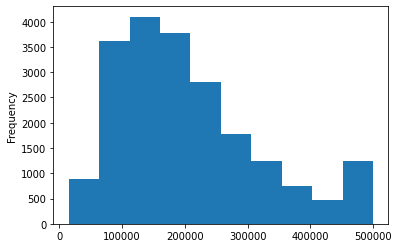

In [34]:
y_full.plot.hist()

In [35]:
y_full[0:10]

0    452600.0
1    358500.0
2    352100.0
3    341300.0
4    342200.0
5    269700.0
6    299200.0
7    241400.0
8    226700.0
9    261100.0
Name: target, dtype: float64

In [36]:
X_train, X_test, y_train, y_test = train_test_split(X_full, y_full, test_size=0.2, random_state=42)

In [37]:
print(X_train.shape)
print(len(y_train))

print(X_test.shape)
print(len(y_test))

(16512, 8)
16512
(4128, 8)
4128


In [38]:
from sklearn.metrics import make_scorer, mean_squared_error

scores = {
    'RMSE': make_scorer(mean_squared_error, greater_is_better=False, squared=False)
}

In [39]:
search_space = hlp.sklearn_search_bayesian.BayesianSearchSpace(
    data=X_train,
    model_type='regression',
    iterations=3,
    random_state=42,
)
search_space.search_spaces()

[({'model': Categorical(categories=(ElasticNet(random_state=42),), prior=None),
   'model__alpha': Real(low=1e-05, high=10, prior='log-uniform', transform='identity'),
   'model__l1_ratio': Real(low=0, high=1, prior='uniform', transform='identity'),
   'prep__numeric__imputer__transformer': Categorical(categories=(SimpleImputer(), SimpleImputer(strategy='median'), SimpleImputer(strategy='most_frequent')), prior=[0.5, 0.25, 0.25]),
   'prep__numeric__scaler__transformer': Categorical(categories=(StandardScaler(), MinMaxScaler()), prior=[0.65, 0.35]),
   'prep__numeric__pca__transformer': Categorical(categories=(None, PCA(n_components='mle')), prior=None),
   'prep__non_numeric__encoder__transformer': Categorical(categories=(OneHotEncoder(handle_unknown='ignore'), CustomOrdinalEncoder()), prior=[0.65, 0.35])},
  3),
 ({'model': Categorical(categories=(ElasticNet(random_state=42),), prior=None),
   'prep__numeric__imputer__transformer': Categorical(categories=(SimpleImputer(),), prior=Non

In [40]:
# pip install scikit-optimize
from skopt import BayesSearchCV
from sklearn.model_selection import RepeatedKFold


_, X_sample, _, y_sample = train_test_split(X_train, y_train, test_size=0.2, random_state=42)
print(X_sample.shape)

bayes_search = BayesSearchCV(
    estimator=search_space.pipeline(),
    search_spaces=search_space.search_spaces(),
    cv=RepeatedKFold(n_splits=5, n_repeats=1, random_state=42),  # 5 fold 2 repeat CV
    #scoring='neg_root_mean_squared_error',
    scoring='neg_mean_absolute_error',
    #scoring=scores,
    refit=False,  # required if passing in multiple scorers
    return_train_score=False,
    #n_jobs=-1,
    verbose=2,
    random_state=42,
)

start_time = time.time()
bayes_search.fit(X_sample, y_sample)
elapsed_time = time.time() - start_time

(3303, 8)
Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] END model=ElasticNet(random_state=42), model__alpha=3.3117333277546708, model__l1_ratio=0.49646670359671674, prep__non_numeric__encoder__transformer=CustomOrdinalEncoder(), prep__numeric__imputer__transformer=SimpleImputer(strategy='median'), prep__numeric__pca__transformer=None, prep__numeric__scaler__transformer=MinMaxScaler(); total time=   0.0s
[CV] END model=ElasticNet(random_state=42), model__alpha=3.3117333277546708, model__l1_ratio=0.49646670359671674, prep__non_numeric__encoder__transformer=CustomOrdinalEncoder(), prep__numeric__imputer__transformer=SimpleImputer(strategy='median'), prep__numeric__pca__transformer=None, prep__numeric__scaler__transformer=MinMaxScaler(); total time=   0.0s
[CV] END model=ElasticNet(random_state=42), model__alpha=3.3117333277546708, model__l1_ratio=0.49646670359671674, prep__non_numeric__encoder__transformer=CustomOrdinalEncoder(), prep__numeric__imputer__transformer=Simpl

In [41]:
print(f"Elapsed time to run BayesSearchCV: {elapsed_time:.3f} seconds; {elapsed_time / 60:.1f} minutes")

Elapsed time to run BayesSearchCV: 415.714 seconds; 6.9 minutes


In [42]:
print(bayes_search.best_score_)

-39744.36656903369


In [43]:
print(bayes_search.best_params_)

OrderedDict([('model', XGBRegressor(base_score=None, booster=None, colsample_bylevel=None,
             colsample_bynode=None, colsample_bytree=None,
             enable_categorical=False, eval_metric='rmse', gamma=None,
             gpu_id=None, importance_type=None, interaction_constraints=None,
             learning_rate=None, max_delta_step=None, max_depth=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=500, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=42, reg_alpha=None, reg_lambda=None,
             scale_pos_weight=None, subsample=None, tree_method=None,
             use_label_encoder=False, validate_parameters=None, verbosity=None)), ('prep__non_numeric__encoder__transformer', OneHotEncoder(handle_unknown='ignore')), ('prep__numeric__imputer__transformer', SimpleImputer()), ('prep__numeric__pca__transformer', None), ('prep__numeric__scaler__transformer', None)])


In [44]:
results = hlp.sklearn_eval.MLExperimentResults.from_sklearn_search_cv(
    searcher=bayes_search,
    higher_score_is_better=False,
    description='BayesSearchCV using Regression Search Space',
    parameter_name_mappings=search_space.param_name_mappings()
)

In [45]:
results.best_score

-39744.36656903369

In [46]:
results.best_params

{'model': 'XGBRegressor()',
 'imputer': 'SimpleImputer()',
 'scaler': 'None',
 'pca': 'None',
 'encoder': 'OneHotEncoder()'}

In [48]:
results.to_formatted_dataframe(return_style=True,
                               include_rank=True,
                               num_rows=1000)

rank,neg_mean_absolute_error Mean,neg_mean_absolute_error 95CI.LO,neg_mean_absolute_error 95CI.HI,model,alpha,l1_ratio,max_features,max_depth,n_estimators,min_samples_split,min_samples_leaf,max_samples,criterion,learning_rate,min_child_weight,subsample,colsample_bytree,colsample_bylevel,reg_alpha,reg_lambda,imputer,scaler,pca,encoder
1,"-39,744.367","-40,967.598","-38,521.135",XGBRegressor(),<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,SimpleImputer(),None,None,OneHotEncoder()
2,"-40,311.908","-42,170.969","-38,452.847",RandomForestRegressor(),<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,SimpleImputer(),None,None,OneHotEncoder()
3,"-44,224.480","-46,567.980","-41,880.981",ExtraTreesRegressor(),<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,SimpleImputer(),None,None,OneHotEncoder()
4,"-47,330.279","-50,585.281","-44,075.277",RandomForestRegressor(),<NA>,<NA>,0.857,30.000,879.000,17.000,28.000,0.563,absolute_error,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,SimpleImputer(strategy='median'),None,None,CustomOrdinalEncoder()
5,"-49,609.021","-51,464.659","-47,753.383",XGBRegressor(),<NA>,<NA>,<NA>,2.000,"1,522.000",<NA>,<NA>,<NA>,<NA>,0.073,12.000,0.976,0.857,0.867,0.016,1.651,SimpleImputer(strategy='most_frequent'),None,PCA('mle'),CustomOrdinalEncoder()
6,"-52,153.840","-54,074.373","-50,233.306",XGBRegressor(),<NA>,<NA>,<NA>,1.000,"1,164.000",<NA>,<NA>,<NA>,<NA>,0.113,2.000,0.709,0.685,0.797,0.037,2.424,SimpleImputer(),None,PCA('mle'),OneHotEncoder()
7,"-52,677.620","-55,092.770","-50,262.469",ElasticNet(random_state=42),0.160,0.872,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,SimpleImputer(strategy='median'),StandardScaler(),None,OneHotEncoder()
8,"-55,212.079","-58,971.771","-51,452.386",XGBRegressor(),<NA>,<NA>,<NA>,1.000,797.000,<NA>,<NA>,<NA>,<NA>,0.015,2.000,0.752,0.850,0.560,0.000,1.079,SimpleImputer(strategy='most_frequent'),None,None,CustomOrdinalEncoder()
9,"-58,547.701","-62,235.960","-54,859.442",ElasticNet(random_state=42),0.807,0.741,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,SimpleImputer(strategy='median'),StandardScaler(),None,OneHotEncoder()
10,"-63,443.298","-65,613.901","-61,272.694",RandomForestRegressor(),<NA>,<NA>,0.672,81.000,"1,136.000",34.000,34.000,0.971,poisson,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,SimpleImputer(strategy='median'),None,PCA('mle'),CustomOrdinalEncoder()
